# Import data

Last updated 26 Dec 2022

Most machine learning algorithms, in `sklearn` for example, operate on data stored in memory only. 

As such, given the sheer sizes of the datasets in this project, the primary challenge is to import the data in such a manner that may be operated upon by the prediction models.

This notebook provides a function written to achieve this. It reads in the original HDF5 data in batches; for each batch, it immediately converts the data to a sparse matrix, and frees up available memory; it then proceeds to the next batch and concatenates the latest imported sparse matrix to existing matrices. 

In this manner, the same information is retained as of the original datasets, but the data sizes are reduced to such an extent that we can construct predictive models using them.

**Data used:**

I use the **Chromium Single Cell Multiome ATAC + Gene Expression** data throughout this project. 

These large datasets do not admit the standard machine learning workflow.

Note that I have mostly eschewed the exploratory data analysis stages in this project. Not because that component is unimportant, but because much useful analyses have already been produced on this subject (see: https://www.kaggle.com/competitions/open-problems-multimodal/code). 

Instead my objective is to provide tools and scripts that are necessary in dealing with large genomic datasets but which are largely absent from off-the-shelf solutions.

In [9]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py
import scipy

In [4]:
data_directory = "/home/jovyan/project/Data/"

cell_metadata = os.path.join(data_directory, "metadata.csv")

cite_train_inputs = os.path.join(data_directory, "train_cite_inputs.h5")
cite_train_targets = os.path.join(data_directory, "train_cite_targets.h5")
cite_test_inputs = os.path.join(data_directory, "test_cite_inputs.h5")

multiome_train_inputs = os.path.join(data_directory, "train_multi_inputs.h5")
multiome_train_targets = os.path.join(data_directory, "train_multi_targets.h5")
multiome_test_inputs = os.path.join(data_directory, "test_multi_inputs.h5")

donor2_day2_cite_test_inputs = os.path.join(data_directory, "test_cite_inputs_day_2_donor_27678.h5")
donor2_day2_cell_metadata = os.path.join(data_directory, "metadata_cite_day_2_donor_27678.csv")

submission_file = os.path.join(data_directory, "sample_submssion.csv")
evaluation_ids = os.path.join(data_directory, "evaluation_ids.csv")

## Multiome data: Chromatin accessibility --> Gene expression

### a. Training data - predictors

In [18]:
df_num = round(105942/1000)
df_list = []

start_row_num = 0
df_multiome_train_x = scipy.sparse.csr_matrix(np.empty((0,228942), dtype = np.float32))

for i in range(df_num):
    df_list.append("df_" + str(i))
    
    for j in df_list:
        j = pd.read_hdf(multiome_train_inputs, start = start_row_num, stop = start_row_num + 1000)
        j = scipy.sparse.csr_matrix(j.values)

        df_multiome_train_x = scipy.sparse.vstack([df_multiome_train_x,j])
        
        gc.collect()
        
        start_row_num += 1001

In [19]:
df_multiome_train_x

<105837x228942 sparse matrix of type '<class 'numpy.float32'>'
	with 606717924 stored elements in Compressed Sparse Row format>

In [20]:
scipy.sparse.save_npz("/home/jovyan/project/Processed Data/df_multiome_train_x.npz", df_multiome_train_x)

### b. Training data - labels

In [27]:
## for dimenion info: https://www.kaggle.com/code/ambrosm/msci-eda-which-makes-sense

# train inputs: 105942 * 228942 float32 values (97 GByte)
# train targets: 105942 * 23418 float32 values (10 GByte)
# test inputs: 55935 * 228942 float32 values (13 GByte)

df_num = round(105942/1000)
df_list = []

start_row_num = 0
df_multiome_train_y = scipy.sparse.csr_matrix(np.empty((0,23418), dtype = np.float32))

for i in range(df_num):
    df_list.append("df_" + str(i))
    
    for j in df_list:
        j = pd.read_hdf(multiome_train_targets, start = start_row_num, stop = start_row_num + 1000)
        j = scipy.sparse.csr_matrix(j.values)
        
        df_multiome_train_y = scipy.sparse.vstack([df_multiome_train_y,j])
        
        gc.collect()
        
        start_row_num += 1001

In [28]:
df_multiome_train_y

<105837x23418 sparse matrix of type '<class 'numpy.float32'>'
	with 406618832 stored elements in Compressed Sparse Row format>

In [29]:
scipy.sparse.save_npz("/home/jovyan/project/Processed Data/df_multiome_train_y.npz", df_multiome_train_y)

### c. Test data - predictors

In [10]:
df_num = round(55935/1000)
df_list = []

start_row_num = 0
df_multiome_test_x = scipy.sparse.csr_matrix(np.empty((0,228942), dtype = np.float32))

for i in range(df_num):
    df_list.append("df_" + str(i))
    
    for j in df_list:
        j = pd.read_hdf(multiome_test_inputs, start = start_row_num, stop = start_row_num + 1000)
        j = scipy.sparse.csr_matrix(j.values)
        
        df_multiome_test_x = scipy.sparse.vstack([df_multiome_test_x,j])
        
        gc.collect()
        
        start_row_num += 1001

In [11]:
df_multiome_test_x

<55880x228942 sparse matrix of type '<class 'numpy.float32'>'
	with 353280741 stored elements in Compressed Sparse Row format>

In [12]:
scipy.sparse.save_npz("/home/jovyan/project/Processed Data/df_multiome_test_x.npz", df_multiome_test_x)

#### Metadata

This is an extra section on the (much smaller in size) metadata. 

This dataset is peripheral to the overall project. But does become useful in UMAP visualisation because we can use the annotated cell types as labels. 

In [10]:
metadata = pd.read_csv(cell_metadata)

In [11]:
metadata.head(n = 10)

,cell_id,day,donor,cell_type,technology
0,c2150f55becb,2,27678,HSC,citeseq
1,65b7edf8a4da,2,27678,HSC,citeseq
2,c1b26cb1057b,2,27678,EryP,citeseq
3,917168fa6f83,2,27678,NeuP,citeseq
4,2b29feeca86d,2,27678,EryP,citeseq
5,0fd801488185,2,27678,EryP,citeseq
6,526647a698f8,2,27678,HSC,citeseq
7,ab8f207a3dec,2,27678,HSC,citeseq
8,57f730249c87,2,27678,MasP,citeseq
9,08df3dcce25c,2,27678,HSC,citeseq


In [12]:
metadata["cell_id"].is_unique

True

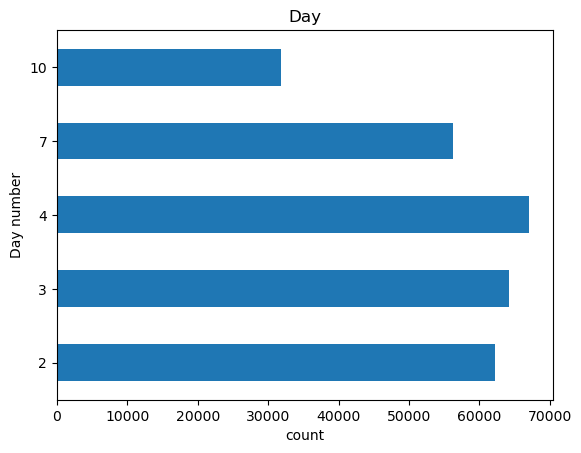

In [13]:
metadata["day"].value_counts(dropna = False).sort_index().plot(kind = "barh")
plt.title("Day")
plt.xlabel("count")
plt.ylabel("Day number")
plt.show()

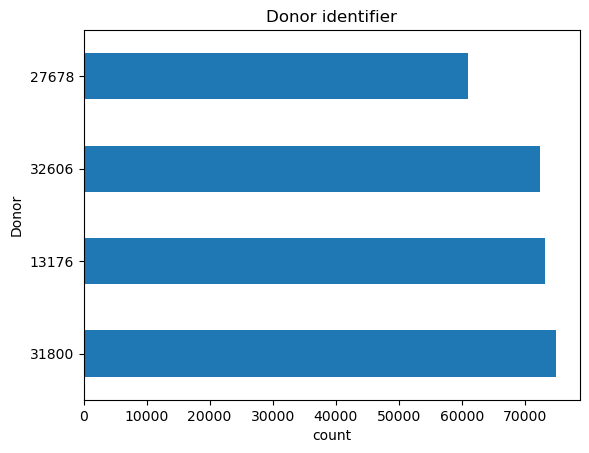

In [14]:
metadata["donor"].value_counts(dropna = False).plot(kind = "barh")
plt.title("Donor identifier")
plt.xlabel("count")
plt.ylabel("Donor")
plt.show()

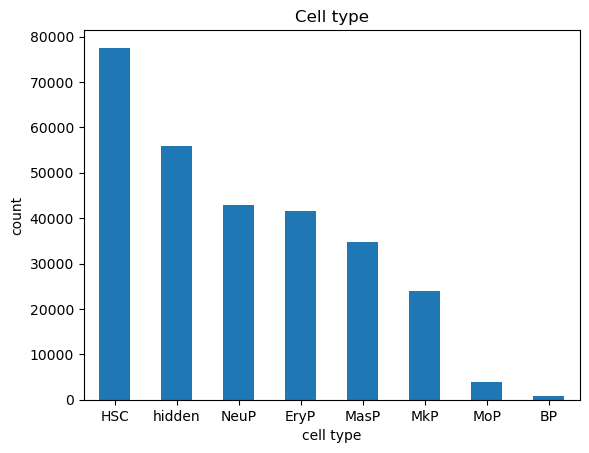

In [15]:
metadata["cell_type"].value_counts(dropna = False).plot(kind = "bar")
plt.title("Cell type")
plt.ylabel("count")
plt.xlabel("cell type")
plt.xticks(rotation = 0)
plt.show()

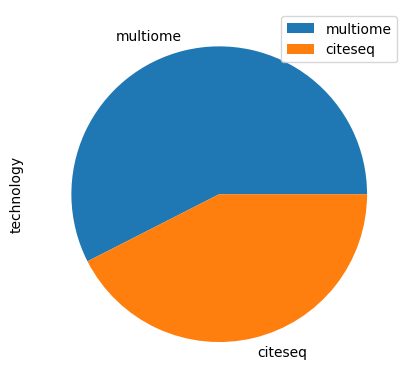

In [16]:
metadata["technology"].value_counts(dropna = False).plot(kind = "pie")
plt.legend()
plt.show()

Each cell, `cell id`, is only measured on one day and one day only. 

In other words, the data does not track the same `cell id` across multiple days.

As such, cannot conduct a time series prediction of using a cell's day *t* gene expression to predict the same cell's day *t+1* gene expression.

In [17]:
(pd.crosstab(metadata["cell_id"],metadata["day"]).sum(axis = "columns")).value_counts(dropna = False)

1    281528
dtype: int64

However, we do have the same `cell type` measured over multiple days.

In [18]:
pd.crosstab(metadata["cell_type"],metadata["day"])

day,2,3,4,7,10
cell_type,,,,,
BP,416,138,156,159,0
EryP,8287,10624,14938,7630,0
HSC,25053,22940,20868,8674,0
MasP,4792,6578,10977,12480,0
MkP,6228,4551,5819,7423,0
MoP,338,772,917,1856,0
NeuP,8215,10601,13436,10727,0
hidden,8921,7950,0,7291,31773


No `cell id` is measured by both technologies.